In [1]:
from google.colab import drive
drive.flush_and_unmount
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
!pip install scikit-video

     |████████████████████████████████| 2.3MB 17.0MB/s 


In [3]:
import json
import time
import cv2
import matplotlib.pyplot as plt
import matplotlib.animation as manimation
import matplotlib.patheffects as pe
import matplotlib.patches as mpatches
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import math
from tqdm import tqdm
from random import sample
import numpy as np
from collections import Counter
import sys
from PIL import Image
import glob
import argparse
import os
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset
import skvideo
import skvideo.io
from torch.utils.data.sampler import Sampler
import pickle

In [4]:
#contains all the supporting functions required
def set_project_folder_dir(if_open_new_folder, local_dir, use_model_folder_dir=False, mode=None):
    if use_model_folder_dir:
        folder_dir = os.path.join(os.path.normpath(local_dir + os.sep + os.pardir), mode)
        create_folder_dir_if_needed(folder_dir)
    else:
        if if_open_new_folder != 'False':
            folder_dir = open_new_folder(if_open_new_folder, local_dir)
        else:
            folder_dir = local_dir
    return folder_dir


def open_new_folder(if_open_new_folder, local_dir):
    if if_open_new_folder == 'True':
        folder_name = time.strftime("%Y%m%d-%H%M%S")
    else:
        folder_name = 'debug'
    folder_dir = os.path.join(local_dir, folder_name)
    create_folder_dir_if_needed(folder_dir)
    return folder_dir


def save_setting_info(args, device, folder_dir):
    setting_file_name = os.path.join(folder_dir, 'setting_info.txt')
    args_dict = args.__dict__
    with open(setting_file_name, 'w') as f:
        for key, value in args_dict.items():
            f.write(key + ' : ' + str(value) + '\n')
        f.write(str(device))


def plot_label_distribution(dataloaders, folder_dir, load_all_data_to_RAM_mode, label_decoder_dict, mode='train'):
    if mode == 'train':
        datasets = [dataloaders[dataloader_name].dataset for dataloader_name in dataloaders.keys()]
        plot_distribution(datasets, list(dataloaders.keys()), load_all_data_to_RAM_mode, folder_dir, label_decoder_dict)
    else:
        plot_distribution([dataloaders.dataset], ['test'], load_all_data_to_RAM_mode, folder_dir, label_decoder_dict)


def plot_distribution(datasets_list, dataset_names_list, load_all_data_to_RAM_mode, folder_dir, label_decoder_dict):
    plt.figure(figsize=(10, 6))
    for index, dataset in enumerate(datasets_list):
        if load_all_data_to_RAM_mode:
            counter_occurrence_of_each_class = Counter(dataset.tensors[1].tolist())
        else:
            counter_occurrence_of_each_class = Counter(dataset.labels)
        with open(os.path.join(folder_dir, 'frequency_of_each_class_{}.pkl'.format(dataset_names_list[index])), 'wb') as f:
            pickle.dump(counter_occurrence_of_each_class, f, pickle.HIGHEST_PROTOCOL)
        sorted_counter = sorted(counter_occurrence_of_each_class.items())
        x, y = zip(*sorted_counter)
        plt.bar(x, y)
    plt.legend(dataset_names_list)
    plt.title('The frequency of each class\n' + '&'.join(dataset_names_list))
    plt.xlabel('label')
    plt.ylabel('Frequency')
    x_ticks_labels = [label_decoder_dict[label_code] for label_code in x]
    plt.xticks(x, x_ticks_labels, fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.xlim(-1, max(x) + 1)
    plt.savefig(os.path.join(folder_dir, '_'.join(dataset_names_list) + '.jpg'), dpi=300, bbox_inches="tight")
    plt.close()



def split_data(ucf_list_root, seed, number_of_classes, split_size, folder_dir):
    print(ucf_list_root, folder_dir)
    video_names_train, video_names_test, labels, labels_decoder_dict = get_video_list(ucf_list_root, number_of_classes, folder_dir)
    print("hello")
    print(video_names_train)
    video_names_train, video_names_val, labels_train, labels_val = train_test_split(video_names_train, labels,
                                                                                    test_size=split_size,
                                                                                    random_state=seed)
    
    save_video_names_test_and_add_labels(video_names_test, labels_decoder_dict, folder_dir, number_of_classes)
    # save labels_decoder_dict
    with open(os.path.join(folder_dir, 'labels_decoder_dict.pkl'), 'wb') as f:
        pickle.dump(labels_decoder_dict, f, pickle.HIGHEST_PROTOCOL)
    return [video_names_train, labels_train], [video_names_val, labels_val], labels_decoder_dict


def get_data(mode, video_names, list, number_of_classes, labels=[]):
    # setting the data files as a list so the not overpower the system
    for video_name in video_names:
        if mode == 'train':
            label = video_name.split('-')[0]
            video_name =  video_name

            label = int(label.rstrip('\n'))
            if number_of_classes is None or label in range(1, number_of_classes + 1):
                labels.append(label-1)
                list.append(video_name.split('.')[0])
            else:
                continue
        else:
            list.append(video_name.split('.')[0])
    return list, labels


def get_video_list(ucf_list_root, number_of_classes, folder_dir):
    # ====== get a list of video names ======
    video_names_train, video_names_test, labels = [], [], []
    sample_train_test_split = str(sample(range(1, 4), 1)[0])
    with open(os.path.join(folder_dir, 'setting_info.txt'), 'a+') as f:
        f.write('\nThe test/train split that we have train on is {}'.format(sample_train_test_split))

      
        videopath = glob.glob(ucf_list_root+"*.avi")
        print("Videopath", videopath)
        video_names = []
        for path in videopath:
          video_names.append(path.split('/')[-1])


        
        video_names_train, labels = get_data('train', video_names, video_names_train, number_of_classes, labels)
        labels_decoder_dict = {1 : "Smoking", 2 : "Not Smoking"}

        video_names_test, _ = get_data('test', video_names, video_names_test, number_of_classes)

    return video_names_train, video_names_test, labels, labels_decoder_dict


def save_video_names_test_and_add_labels(video_names_test, labels_decoder_dict, folder_dir, number_of_classes):
    save_test_video_details = os.path.join(folder_dir, 'test_videos_detailes.txt')
    with open(save_test_video_details, 'w') as f:
        for text_video_name in video_names_test:
            label_string = text_video_name.split('/')[0]
            # endoce label
            for key, value in labels_decoder_dict.items():
                if value == label_string:
                    label_code = key
                else:
                    continue
                if number_of_classes is None or label_code in range(0, number_of_classes):
                    f.write(text_video_name + ' ' + str(label_code) + '\n')
                else:
                    continue


def plot_images_with_predicted_labels(local_x, label_decoder_dict, predicted_labels, folder_dir, epoch):
    print("labl Dic")
    print(label_decoder_dict)
    print("PredictedLabels")
    print(predicted_labels)
    folder_save_images = os.path.join(folder_dir, 'Images')
    create_folder_dir_if_needed(folder_save_images)
    n_rows = math.trunc(math.sqrt(len(local_x)))
    n_cols = n_rows
    if n_rows == 1 and n_cols == 1:
        plot_single_images_with_predicted_labels(local_x, label_decoder_dict, predicted_labels, folder_save_images, epoch)
    else:
        fig, ax = plt.subplots(ncols=n_cols, nrows=n_rows, figsize=(10, 10))
        for row in range(n_rows):
            for col in range(n_cols):
                img = local_x[col + (row * n_cols)][0].permute(1, 2, 0)
                img_scale = (img - img.min()) / (img.max() - img.min())
                ax[row, col].imshow(img_scale)
                label_for_title = label_decoder_dict[predicted_labels[col + (row * n_cols)].item()]
                #label_for_title = str(predicted_labels[col + (row * n_cols)].item())
                ax[row, col].set_title(label_for_title)
                ax[row, col].set_xticks([])
                ax[row, col].set_yticks([])
        plt.savefig(os.path.join(folder_save_images, 'predicted_labels {} epoch.png'.format(epoch)))
        plt.close()


def plot_single_images_with_predicted_labels(local_x, label_decoder_dict, predicted_labels, folder_save_images, epoch):
    fig, ax = plt.subplots(figsize=(10, 10))
    img = local_x[0][0].permute(1, 2, 0)
    img_scale = (img - img.min()) / (img.max() - img.min())
    ax.imshow(img_scale)
    label_for_title = label_decoder_dict[predicted_labels[0].item()]
    ax.set_title(label_for_title)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.savefig(os.path.join(folder_save_images, 'predicted_labels {} epoch.png'.format(epoch)))
    plt.close()


def create_folder_dir_if_needed(folder_save_dir):
    if not os.path.exists(folder_save_dir):
        os.makedirs(folder_save_dir)



def load_all_dataset_to_RAM(dataloaders, dataset_order, batch_size):
    images_train, labels_train, images_val, labels_val = [], [], [], []
    for i, mode in enumerate(['train', 'val']):
        images_list = [images_train, images_val][i]
        labels_list = [labels_train, labels_val][i]
        with tqdm(total=len(dataloaders[mode])) as pbar:
            # with tqdm_notebook(total=len(dataloaders[mode])) as pbar:
            for local_images, local_label in dataloaders[mode]:
                images_list += [local_images]
                labels_list += [local_label]
                pbar.update(1)
    images_train = torch.cat(images_train, axis=0)
    labels_train = torch.cat(labels_train, axis=0)
    images_val = torch.cat(images_val, axis=0)
    labels_val = torch.cat(labels_val, axis=0)
    datasets = {dataset_order[index]: TensorDataset(x[0], x[1]) for index, x in
                enumerate([[images_train, labels_train], [images_val, labels_val]])}
    dataloaders = {x: DataLoader(datasets[x], batch_size=batch_size, shuffle=True)
                   for x in ['train', 'val']}
    return dataloaders


def load_all_dataset_to_RAM_test(dataloader, batch_size):
    images_test, labels_test = [], []
    with tqdm(total=len(dataloader)) as pbar:
        
        for local_images, local_label in dataloader:
            images_test += [local_images]
            labels_test += [local_label]
            pbar.update(1)
    images_test = torch.cat(images_test, axis=0)
    labels_test = torch.cat(labels_test, axis=0)
    dataset = TensorDataset(images_test, labels_test)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader


def foward_step_no_labels(model, images):
    # Must be done before you run a new batch. Otherwise the LSTM will treat a new batch as a continuation of a sequence
    model.Lstm.reset_hidden_state()
    with torch.no_grad():
        output = model(images)
    predicted_labels = output.detach().cpu().argmax(dim=1)
    return predicted_labels


def foward_step(model, images, labels, criterion, mode=''):  # predections
    # Must be done before you run a new batch. Otherwise the LSTM will treat a new batch as a continuation of a sequence
    model.Lstm.reset_hidden_state()
    if mode == 'test':
        with torch.no_grad():
            output = model(images)
    else:
        output = model(images)
    loss = criterion(output, labels)
    # Accuracy calculation
    predicted_labels = output.detach().argmax(dim=1)
    acc = (predicted_labels == labels).cpu().numpy().sum()
    return loss, acc, predicted_labels.cpu()


def train_model(model, dataloader, device, optimizer, criterion):
    train_loss, train_acc = 0.0, 0.0
    model.train()
    with tqdm(total=len(dataloader)) as pbar:
        # with tqdm_notebook(total=len(dataloader)) as pbar:
        for local_images, local_labels, ___ in dataloader:
            local_images, local_labels = local_images.to(device), local_labels.to(device)
            optimizer.zero_grad()  # zero the parameter gradients
            loss, acc, ___ = foward_step(model, local_images, local_labels, criterion, mode='train')
            train_loss += loss.item()
            train_acc += acc
            loss.backward()  # compute the gradients
            optimizer.step()  # update the parameters with the gradients
            pbar.update(1)
    train_acc = 100 * (train_acc / dataloader.dataset.__len__())
    train_loss = train_loss / len(dataloader)
    return train_loss, train_acc


def test_model(model, dataloader, device, criterion, mode='test'):
    val_loss, val_acc = 0.0, 0.0
    model.eval()
    if mode == 'save_prediction_label_list':
        prediction_labels_list = []
        true_labels_list = []
    with tqdm(total=len(dataloader)) as pbar:
        # with tqdm_notebook(total=len(dataloader)) as pbar:
        for local_images, local_labels, indexs in dataloader:
                local_images, local_labels = local_images.to(device), local_labels.to(device)
                loss, acc, predicted_labels = foward_step(model, local_images, local_labels, criterion, mode='test')
                if mode == 'save_prediction_label_list':
                    prediction_labels_list += [predicted_labels.detach().cpu()]
                    true_labels_list += [local_labels.detach().cpu()]
                val_loss += loss.item()
                val_acc += acc
                pbar.update(1)
    val_acc = 100 * (val_acc / dataloader.dataset.__len__())
    val_loss = val_loss / len(dataloader)
    if mode == 'save_prediction_label_list':
        return val_loss, val_acc, prediction_labels_list, local_images.cpu(), true_labels_list, indexs
    else:
        return val_loss, val_acc, predicted_labels, local_images.cpu()


def test_model_continues_movie(model, dataloader, device, criterion, save_path, label_decoder_dict):
    val_loss, val_acc = 0.0, 0.0
    model.eval()
    # ====== choosing one random batch from the dataloader ======
    dataloader_iter = iter(dataloader)
    images, labels, ___ = next(dataloader_iter)
    predicted_labels_list = []
    # ===== create continues movie and labels tensor, with X frames from each movie ======
    # ===== and stack a sliding window of size 5 frames to new dim so they will act as batch ======
    num_frames_to_sample = images.shape[1]
    sliding_window_images, continues_labels, continues_movie = create_sliding_window_x_frames_size_dataset\
        (images, labels, num_frames_to_sample)
    # ====== predict the label of each sliding window, use batches because of GPU memory ======
    for batch_boundaries in range(0, len(sliding_window_images), dataloader.batch_size):
        batch_images_to_plot = sliding_window_images[batch_boundaries: batch_boundaries + dataloader.batch_size].to(
            device)
        batch_labels = continues_labels[batch_boundaries: batch_boundaries + dataloader.batch_size].to(device)
        loss, acc, predicted_labels = foward_step(model, batch_images_to_plot, batch_labels, criterion, mode='test')
        predicted_labels_list += [predicted_labels]
        val_acc += acc
    predicted_labels = torch.cat(predicted_labels_list, axis=0)
    val_loss += loss.item()
    create_video_with_labels(save_path, 'Video_with_prediction_vs_true_labels.avi', continues_movie, continues_labels,
                             predicted_labels, label_decoder_dict, mode='continues_test_movie')
    save_path_plots = os.path.join(save_path, 'Plots')
    create_folder_dir_if_needed(save_path_plots)
    plot_sliding_window_prediction_for_each_frame(continues_labels, predicted_labels, save_path_plots,
                                                  label_decoder_dict, labels)
    plot_function_of_num_frames_in_window_on_prediction(continues_labels, predicted_labels, save_path_plots,
                                                        num_frames_to_sample)
    val_acc = 100 * (val_acc / len(sliding_window_images))
    val_loss = val_loss / len(dataloader)
    return val_loss, val_acc, predicted_labels, images.cpu()


def test_model_continues_movie_youtube(model, data, device, save_path, label_decoder_dict, batch_size,
                                       preprocessing_movie_mode, dataset_type='youtube', video_original_size=None, vid=None, pth=None):
    model.eval()
    if preprocessing_movie_mode == 'preprocessed':
        # ====== choosing one random batch from the dataloader ======
        dataloader_iter = iter(data)
        images = next(dataloader_iter)
        images = images.squeeze(0)
        video_original_size = video_original_size[dataloader_iter._dataset.images[0].split('.avi')[0]]
    else:
        images = data

    num_frames_to_sample = 5
    cfps = 10

    # ===== create continues movie and labels tensor, with X frames from each movie ======
    # ===== and stack a sliding window of size 5 frames to new dim so they will act as batch ======

    sliding_window_images = create_sliding_window_x_frames_size_dataset \
        (images, None, num_frames_to_sample, dataset_type)

    # ====== predict the label of each sliding window, use batches beacuse of GPU memory ======

    predicted_labels = predict_labels_of_sliding_window(sliding_window_images, batch_size, device, model)

    #f_labels = [1 for _ in range(num_frames_to_sample - 1)] + predicted_labels

    print("Len of predicted labels", len(predicted_labels))
    model_prediction= predicted_labels.tolist()
    f_labels = [1 for _ in range(num_frames_to_sample - 1)] + model_prediction + [1]
    print("f_labelslen", len(f_labels))
    print(f_labels)
    video = cv2.VideoCapture(os.path.join(pth, vid))
    fps = video.get(cv2.CAP_PROP_FPS)

    start = 0
    end = 0
    flag = False
    moments=[]
    moments_in_seconds = []
    for i in range(len(f_labels)):
      if f_labels[i] == 0 and not flag:
        start = i
        flag = True
      if flag and f_labels[i] == 1:
        moments.append([start,i-1])
        s, e = moments[-1]
        moments_in_seconds.append([(s/fps), (e/fps)]) 
        flag = False

    print(moments)
    print(moments_in_seconds)

    save_path_plots = os.path.join(save_path, 'Plots')
    create_folder_dir_if_needed(save_path_plots)
    plot_sliding_window_prediction_for_each_frame_no_labels(predicted_labels, save_path_plots, label_decoder_dict)
    # create_video_with_labels(save_path, 'Video_with_prediction_vs_true_labels.avi',
    #                          images[:len(images) - num_frames_to_sample + 1], None, predicted_labels,
    #                          label_decoder_dict,
    #                          video_original_size=video_original_size, fps=cfps, mode='youtube')
    return moments_in_seconds

def create_sliding_window_x_frames_size_dataset(local_images, local_labels, num_frames_to_sample,
                                                dataset_type='UCF101'):
    """"
    This function would join all of the images in the batch to one long continues movie, which would be
    composed from num_batch human action movies (shape - num_batch*num_frames_to_sample, 3, 224, 224).
    Than, a sliding window of num_frames_to_sample would be passed on the continues movie,
    creating a stack of mini videos that can be used as an input to the LRCN network.
    (shape - (num_batch - num_frames_to_sample+1), num_of_frames_to_samples, 3, 224, 224)
    The label for each sliding window would be set according the majority of frames we have for each action,
    meaning if the sliding window has 3 frames from the first action and two from the next action, the label of the sliding
    window would be the first action
    """
    # ===== create continues movie, with X frames from each movie ======
    if dataset_type == 'UCF101':
        local_images = local_images[:, :num_frames_to_sample]
        continues_frames = local_images.view(local_images.shape[0] * local_images.shape[1], local_images.shape[2],
                                             local_images.shape[3], local_images.shape[4])
    else:
        continues_frames = local_images
    sliding_window_images = []
    
    for num_frame in range(continues_frames.shape[0] - num_frames_to_sample + 1):
        # ===== normalize the frames according to the imagenet preprocessing =======
        sliding_window_images += [continues_frames[num_frame: num_frame + num_frames_to_sample]]
    sliding_window_images = torch.stack(sliding_window_images)
    continues_frames = continues_frames[:len(sliding_window_images)]
    if dataset_type == 'UCF101':
        # ==== create continues label tensor where each frame has its own label ======
        majority_of_num_of_frames = math.ceil(
            num_frames_to_sample / 2) if num_frames_to_sample % 2 != 0 else num_frames_to_sample / 2 + 1
        majority_of_num_of_frames = int(majority_of_num_of_frames)
        print("Majority_of_num_frames ",majority_of_num_of_frames)
        mid_continues_labels = local_labels[1:len(local_labels) - 1].view(-1, 1).repeat(1, num_frames_to_sample).view(
            -1)
        start_continues_labels = local_labels[0].view(-1, 1).repeat(1, majority_of_num_of_frames).view(-1)
        end_continues_labeels = local_labels[-1].view(-1, 1).repeat(1, majority_of_num_of_frames).view(-1)
        continues_labels = torch.cat((start_continues_labels, mid_continues_labels, end_continues_labeels))
        return sliding_window_images, continues_labels, continues_frames
    else:
        return sliding_window_images


def plot_function_of_num_frames_in_window_on_prediction(continues_labels, predicted_labels, save_path_plots,
                                                        num_frames_to_sample):
    mean_acc_array = []
    for num_frames in range(num_frames_to_sample):
        predicted_labels_with_num_frames_in_window = np.array(
            [predicted_labels[i] for i in range(num_frames, len(predicted_labels), num_frames_to_sample)])
        labels_with_num_frames = np.array(
            [continues_labels[i] for i in range(num_frames, len(continues_labels), num_frames_to_sample)])
        print("hello")
        print(predicted_labels_with_num_frames_in_window == labels_with_num_frames)

        
        mean_acc_array += [0 / len(
            labels_with_num_frames) * 100]
    mean_acc_array.reverse()
    x_axis = np.arange(num_frames_to_sample)
    plt.plot(x_axis, mean_acc_array, linestyle='-', marker="o")
    plt.xticks(x_axis, np.arange(num_frames_to_sample, 0, -1))
    plt.xlabel('Number of frames from a specific human action')
    plt.ylabel('Mean accuracy [%]')
    plt.ylim(0, 100)
    plt.title('Change in accuracy with the change in frame num')
    plt.savefig(os.path.join(save_path_plots, 'analysis_of_predicted_labels_in_sliding_window.png'), dpi=300,
                bbox_inches='tight')
    plt.close()


def save_loss_info_into_a_file(train_loss, val_loss, train_acc, val_acc, folder_dir, epoch):
    file_name = os.path.join(folder_dir, 'loss_per_epoch.txt')
    with open(file_name, 'a+') as f:
        f.write('Epoch {} : Train loss {:.8f}, Train acc {:.4f}, Val loss {:.8f}, Val acc {:.4f}\n'
                .format(epoch, train_loss, train_acc, val_loss, val_acc))


def set_transforms(mode):
    if mode == 'train':
        transform = transforms.Compose(
            [transforms.Resize(256),  # this is set only because we are using Imagenet pre-train model.
             transforms.RandomCrop(224),
             transforms.RandomHorizontalFlip(),
             transforms.ToTensor(),
             transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                  std=(0.229, 0.224, 0.225))
             ])
    elif mode == 'test' or mode == 'val':
        transform = transforms.Compose([transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                             std=(0.229, 0.224, 0.225))])
    return transform


def create_new_video(save_path, video_name, image_array):
    
    (h, w) = image_array[0].shape[:2]
    if len(video_name.split('/')) > 1:
        video_name = video_name.split('/')[1]
    else:
        video_name = video_name.split('.mp4')[0]
        video_name = video_name + '.avi'
    save_video_path = os.path.join(save_path, video_name)
    output_video = cv2.VideoWriter(save_video_path, cv2.VideoWriter_fourcc(*'MJPG'), 5, (w, h), True)
    for frame in range(len(image_array)):
        output_video.write(image_array[frame])
    output_video.release()
    cv2.destroyAllWindows()


def create_video_with_labels(save_path, video_name, image_array, continues_labels, predicted_labels, label_decoder_dict,
                             video_original_size=None, fps=2.5, mode='single_movie'):
    if mode == 'single_movie':
        predicted_labels = torch.tensor(predicted_labels)
        predicted_labels = predicted_labels.view(-1, 1).repeat(1, len(image_array)).view(-1)
    path_save_videos = os.path.join(save_path, 'Videos')
    create_folder_dir_if_needed(path_save_videos)
    dpi = 300
    w, h = setting_video_size(video_original_size)
    image_array = F.interpolate(image_array, size=(h, w))
    image_array = image_array.transpose(2, 1).transpose(2, 3)
    n_frames = len(image_array)
    figure_size_w = round((w - 50) / float(dpi) * 2)
    figure_size_h = round(h / float(dpi) * 3)
    h_fig = plt.figure(figsize=(figure_size_w, figure_size_h), dpi=dpi)
    # ====== plot frame, would change with every frame ======
    if mode != 'youtube':
        h_ax = h_fig.add_axes([0.08, 0.25, 0.85, 0.8])
    else:
        h_ax = h_fig.add_axes([0.03, 0.1, 0.95, 0.95])
    img = (image_array[0] - image_array[0].min()) / (image_array[0].max() - image_array[0].min())
    h_im = h_ax.matshow(img)
    h_ax.set_axis_off()
    h_im.set_interpolation('none')
    h_ax.set_aspect('equal')
    # ======== plot the label prediction with the frame =====
    if mode != 'youtube':
        h_ax_plot = h_fig.add_axes([0.08, 0.25, 0.85, 0.05])
    else:
        h_ax_plot = h_fig.add_axes([0.03, 0.25, 0.95, 0.04])
    # h_ax_plot = h_fig.add_axes([0.1, 0.22, 0.8, 0.06])
    x_array = np.arange(len(predicted_labels)) + 0.5
    y_array = np.zeros(len(x_array))
    bool_array = None if continues_labels is None else continues_labels == predicted_labels
    color_dict = create_color_dict(predicted_labels)
    color_list = []
    h_text_object = set_text_to_video_frame(continues_labels, label_decoder_dict,
                                            predicted_labels, mode, bool_array=bool_array)

    FFMpegWriter = manimation.writers['ffmpeg']
    metadata = dict(title=video_name, artist='Matplotlib')
    writer = FFMpegWriter(fps=fps, metadata=metadata)
    with writer.saving(h_fig, os.path.join(path_save_videos, video_name), dpi=dpi):  # change from 600 dpi
        for i in range(n_frames):
            set_text_to_video_frame(continues_labels, label_decoder_dict,
                                    predicted_labels, mode, h_text_object=h_text_object, bool_array=bool_array, frame=i)
            img = (image_array[i] - image_array[i].min()) / (image_array[i].max() - image_array[i].min())
            h_im.set_array(img)
            if i > 0:
                h_im_2.remove()
            y_array[:i + 1] = 1
            if mode != 'continues_test_movie':
                color_list += [color_dict[predicted_labels[i].item()]]
            else:
                color_list += ['green' if bool_array[i].item() else color_dict[predicted_labels[i].item()]]
            h_im_2 = h_ax_plot.bar(x_array, y_array, color=color_list, width=1.0)
            h_ax_plot.get_yaxis().set_ticks([])
            h_ax_plot.set_ylim(0, 1)
            h_ax_plot.tick_params(axis="x", labelsize=4)
            h_ax_plot.set_xlim(0, len(x_array))
            writer.grab_frame()
    plt.close()


def setting_sample_rate(num_frames_to_extract, sampling_rate, video, fps, ucf101_fps):
    video.set(cv2.CAP_PROP_POS_AVI_RATIO, 1)
    # video_length = video.get(cv2.CAP_PROP_POS_MSEC) / 1000
    # print("video_lenght", video_length, fps )
    # num_frames = int(video_length * fps)

    # print("Total frames: ", num_frames)
    
    # video_length = video.get(cv2.CAP_PROP_POS_MSEC)
    # print("VideoLenght", video_length)

    # cal_fps = video.get(cv2.CAP_PROP_FPS)

    # print("FPS :",cal_fps)
    
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    # print( num_frames )

    # num_frames = int(video_length * fps)
    print("number of frames", num_frames)

    if num_frames_to_extract == 'all':
        sample_start_point = 0
        if fps != ucf101_fps and sampling_rate != 0:
            sampling_rate = math.ceil(fps / (ucf101_fps / sampling_rate))
    elif video_length < (num_frames_to_extract * sampling_rate):
        print("hellp vp")
        sample_start_point = 0
        sampling_rate = 2
    else:
        sample_start_point = sample(range(num_frames - (num_frames_to_extract * sampling_rate)), 1)[0]
    return sample_start_point, sampling_rate, num_frames


def capture_and_sample_video(row_data_dir, video_name, num_frames_to_extract, sampling_rate, fps, save_path,
                             ucf101_fps, processing_mode):
    video = cv2.VideoCapture(os.path.join(row_data_dir, video_name))
    
    if fps == 'Not known':
        fps = video.get(cv2.CAP_PROP_FPS)
    video_width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    video_height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    

    # video_length = video.get(cv2.CAP_PROP_POS_MSEC)
    # print("VideoLength", video_length)

    fps = 30
    
    #video.get(cv2.CAP_PROP_FPS)
    ucf101_fps = video.get(cv2.CAP_PROP_FPS)

    print("FPS :",ucf101_fps)
    
    num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    print("total number of frames",num_frames)
    sample_start_point = 0

    # sample_start_point, sampling_rate, num_frames = setting_sample_rate(num_frames_to_extract, sampling_rate, video,
    #                                                                      fps, ucf101_fps)
    print("Details: ", sample_start_point, sampling_rate, num_frames)
    # ====== setting the video to start reading from the frame we want ======
    image_array = []
    if num_frames_to_extract == 'all':
        num_frames_to_extract = int(num_frames / sampling_rate) if sampling_rate != 0 else num_frames
    
    print("frames to extract",num_frames_to_extract)

    if processing_mode == 'live':
        transform = set_transforms(mode='test')
    for frame in range(num_frames_to_extract):
        video.set(1, sample_start_point)
        success, image = video.read()
        if not success:
            print('Error in reading frames from row video')
        else:
            RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) if processing_mode == 'live' else image
            image = Image.fromarray(RGB_img.astype('uint8'), 'RGB')
            if processing_mode == 'live':
                image_array += [transform(image)]
            else:
                image_array += [np.uint8(image)]
        sample_start_point = sample_start_point + sampling_rate
    video.release()
    if processing_mode == 'main':
        create_new_video(save_path, video_name, image_array)
    
    return image_array, [video_width, video_height]


def load_test_data(test_dir, mode='load_all'):


    videopath = glob.glob(test_dir+"*.avi")

    print("Videopath", videopath)

    video_names = []
    for path in videopath:
        print(path.split('/')[-1])
        video_names.append(path.split('/')[-1].split(".")[0])

    if mode == 'load_all':
        test_videos_names, labels = [], []
        for video_name_with_label in video_names:
            label = video_name_with_label.split('-')[0]
            test_videos_names += [video_name_with_label]
            labels += [int(label) - 1]

    labels_decoder_dict = {0 : "Smoking", 1 : "Not Smoking"}
    if mode == 'load_all':
        return test_videos_names, labels, labels_decoder_dict
    else:
        return labels_decoder_dict

  

def plot_confusion_matrix(predicted_labels, true_labels, label_decoder_dict, save_path):
    class_order_to_plot = list(label_decoder_dict.keys())[:true_labels.max() + 1]
    cm = confusion_matrix(true_labels, predicted_labels, labels=class_order_to_plot, normalize='true')
    # ==== plot the cm as heatmap ======
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='none', aspect='auto', cmap=plt.cm.Blues)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=10)
    x_labels = [label_decoder_dict[label_code] for label_code in class_order_to_plot]
    plt.xticks(class_order_to_plot, x_labels, rotation=90, fontsize=6)
    plt.yticks(class_order_to_plot, x_labels, fontsize=6)
    plt.ylim(len(class_order_to_plot), -0.5)
    plt.title('Normalized confusion matrix')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'Normalized_confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.close()


def plot_acc_per_class(predicted_labels, true_labels, label_decoder_dict, save_path):
    # ===== count the number of times each class appear in the test data =====
    frequency_of_each_class = Counter(true_labels.tolist())
    # ===== load the frequency counter for the train dataset, would be used to mark low frequency classes =====
    global_dir = os.path.normpath(save_path + os.sep + os.pardir + os.sep + os.pardir)
    with open(os.path.join(global_dir, 'frequency_of_each_class_train.pkl'), 'rb') as f:
        frequency_of_each_class_train = pickle.load(f)
    # ===== count the number of times each class is labeled correctly =======
    class_list = list(label_decoder_dict.keys())[: true_labels.max() + 1]
    acc = true_labels == predicted_labels
    counter_correct_labeled = Counter()
    for index, true_label in enumerate(true_labels):
        counter_correct_labeled[true_label.item()] += acc[index].item()
    # ==== calculate the accuracy to predict each class =====
    acc_per_class = []
    mean_frequency = sum(list(frequency_of_each_class_train.values())) / len(frequency_of_each_class_train)
    classes_with_lower_frequency_compare_to_average = []
    for class_ in class_list:
        acc_per_class += [counter_correct_labeled[class_] / frequency_of_each_class[class_] * 100]
        if frequency_of_each_class_train[class_] <= (0.9 * mean_frequency):
            classes_with_lower_frequency_compare_to_average += [class_]
    acc_classes_with_lower_frequency_compare_to_average = [acc_per_class[class_] for class_ in
                                                           classes_with_lower_frequency_compare_to_average]
    plt.figure(figsize=(10, 10))
    plt.bar(class_list, acc_per_class)
    plt.bar(classes_with_lower_frequency_compare_to_average, acc_classes_with_lower_frequency_compare_to_average,
            color='red')
    x_labels = [label_decoder_dict[label_code] for label_code in class_list]
    plt.xticks(class_list, x_labels, rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.xlabel('Classes', fontsize=16)
    plt.ylabel('Accuracy [%]', fontsize=16)
    plt.xlim(-1, class_list[-1] + 1)
    plt.ylim(0, 109)
    plt.legend(['freq > 0.9 * avr freq of a class', 'freq <= 0.9 * avr freq of a class'])
    plt.title('The accuracy score for each class', fontsize=18)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, 'The_accuracy_score_for_each_class.png'), dpi=300, bbox_inches='tight')
    plt.close()


def check_if_batch_size_bigger_than_num_classes(batch_size, num_of_classes):
    if num_of_classes is None:
        num_of_classes = 101
    if batch_size > num_of_classes:
        print(
            'Your batch size is bigger than the num of classes you are testing. This would cause an Error in the custom sampler. Your options are:\n'
            '1. Reduce the batch size so it would be smaller or equal to the number of classes you are testing.\n'
            '2. Reduce the number of classes so it would be bigger or equal to the batch size.\n'
            '3. Stop using the custom sampler: erase the sampler parameter from the dataloader and change the shuffle '
            'parameter to True.')
        sys.exit()


def plot_sliding_window_prediction_for_each_frame(continues_labels, predicted_labels, save_path_plots,
                                                  label_decoder_dict, original_order_of_labels):
  
    max_label_code = max(max(predicted_labels).item(), max(continues_labels).item())
    print("MAx label code")
    print(max_label_code)

    predicted_labels_one_hot = create_one_hot_vector_matrix(predicted_labels.numpy(), max_label_code)

    labels_one_hot = create_one_hot_vector_matrix(continues_labels.numpy(), max_label_code)
    labels_one_hot = labels_one_hot * 2
    one_hot_matrix_to_plot = predicted_labels_one_hot + labels_one_hot
    labels_new_order = original_order_of_labels.cpu().detach().numpy()
    #one_hot_matrix_to_plot, labels_new_order = resort_matrix(original_order_of_labels, one_hot_matrix_to_plot)
    one_hot_matrix_to_plot = one_hot_matrix_to_plot[~np.all(one_hot_matrix_to_plot == 0, axis=1)]
    one_hot_matrix_to_plot = np.apply_along_axis(increase_the_error_value_for_non_neighbors_labels, 0,
                                                 one_hot_matrix_to_plot)
    plt.figure(figsize=(12, 10))
    if 5 not in np.unique(one_hot_matrix_to_plot):
        one_hot_matrix_to_plot = np.vstack((one_hot_matrix_to_plot, np.full((1, one_hot_matrix_to_plot.shape[1]), 5)))
        im = plt.imshow(one_hot_matrix_to_plot[:-1,:], cmap='bwr', aspect='auto')
        values = ['None', 'Predicted_labels_next_movie', 'true_label', 'predicted_label_is_true_label']
    else:
        im = plt.imshow(one_hot_matrix_to_plot, cmap='bwr', aspect='auto')
        values = ['None', 'Predicted_labels_next_movie', 'true_label', 'predicted_label_is_true_label', 'Predicted_label_errors']
    skip_x_ticks = math.ceil(len(continues_labels) / 15)
    x_array = np.arange(0, len(continues_labels), skip_x_ticks)
    print("labelneworder")
    print(labels_new_order)
    y_labels = [label_decoder_dict[label_code] for label_code in labels_new_order]
    plt.ylim(len(y_labels), -0.3)
    plt.xticks(x_array, x_array, fontsize=10)
    plt.yticks(np.arange(len(labels_new_order)), y_labels, fontsize=10)
    # ==== create coustomize legand to the heat map =====
    colors = [im.cmap(im.norm(value)) for value in range(len(values))]
    patches = [mpatches.Patch(color=colors[i], label=values[i], edgecolor='b') for i in
               range(len(values))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5, frameon=True)
    plt.title('Label Prediction in each frame', fontsize=14)
    plt.savefig(os.path.join(save_path_plots, 'change_in_accuracy_with_the_movment_of_sliding_window.png'), dpi=300,
                bbox_inches='tight')
    plt.close()


def create_one_hot_vector_matrix(array, array_max):
    one_hot_array = np.zeros((array.size, array_max + 1))
    one_hot_array[np.arange(array.size), array] = 1
    one_hot_array = one_hot_array.transpose()
    return one_hot_array


def resort_matrix(labels_order, matrix):
    # print(labels_order)
    # print(matrix.shape)
    
    sorted_matrix = np.zeros(matrix.shape)
    classes_that_we_plotted = []
    for row_index, label in enumerate(labels_order):
        if label.item() in classes_that_we_plotted:
            pass
        else:
            sorted_matrix[row_index] = matrix[label.item()]
            classes_that_we_plotted += [label.item()]
    index_of_filled_rows = row_index + 1

    for index in range(len(matrix)):
        if index in classes_that_we_plotted:
            pass
        else:
            sorted_matrix[index_of_filled_rows] = matrix[index]
            index_of_filled_rows += 1
            if np.nonzero(matrix[index])[0].size != 0 and index not in classes_that_we_plotted:
                classes_that_we_plotted += [index]
    return sorted_matrix, classes_that_we_plotted


def increase_the_error_value_for_non_neighbors_labels(matrix_col):
    indices_of_non_zero_elements = np.nonzero(matrix_col)
    if len(indices_of_non_zero_elements[0]) > 1:
        dist_between_indices = indices_of_non_zero_elements[0][1] - indices_of_non_zero_elements[0][0]
        if dist_between_indices > 1:
            matrix_col[matrix_col == 1] = 5
    return matrix_col


def print_dataset_type_error():
    print(
        'You have enter a wrong dataset type in the dataset function. please fix it. possabilites are youtube or UCF101(the default)')
    sys.exit()


def plot_sliding_window_prediction_for_each_frame_no_labels(predicted_labels, save_path_plots, label_decoder_dict):
    original_order_of_labels = []
    for label in predicted_labels:
        if label.item() in original_order_of_labels:
            pass
        else:
            original_order_of_labels += [label]
    one_hot_matrix_to_plot = create_one_hot_vector_matrix(predicted_labels.numpy(), max(predicted_labels).item())
    one_hot_matrix_to_plot, ____ = resort_matrix(original_order_of_labels, one_hot_matrix_to_plot)
    one_hot_matrix_to_plot = one_hot_matrix_to_plot[~np.all(one_hot_matrix_to_plot == 0, axis=1)]
    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(one_hot_matrix_to_plot, cmap='GnBu', aspect='auto')
    skip_x_ticks = math.ceil(len(predicted_labels) / 15)
    x_array = np.arange(0, len(predicted_labels), skip_x_ticks)
    y_labels = [label_decoder_dict[label_code.item()] for label_code in original_order_of_labels]
    y_ticks = np.arange(len(original_order_of_labels))
    ax.set_ylim(len(y_labels), -0.3)
    ax.set_xticklabels(x_array, fontsize=10)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels, fontsize=10)
    # ==== create coustomize legand to the heat map =====
    values = ['None', 'Predicted_labels']
    colors = [im.cmap(im.norm(value)) for value in range(len(values))]
    patches = [mpatches.Patch(color=colors[i], label=values[i], edgecolor='b') for i in
               range(len(values))]
    plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5, frameon=True)
    plt.title('Label Prediction in each frame', fontsize=14)
    plt.savefig(os.path.join(save_path_plots, 'change_in_accuracy_with_the_movement_of_sliding_window.png'), dpi=300,
                bbox_inches='tight')


def print_error_preprocessing_movie_mode():
    print('Your value in the pre-processing movie mode is incorrect. your options are:\n'
          '1. live pre-processing.\n'
          '2. pre-processied movie. \n'
          'please choose one of them')
    sys.exit()


def predict_labels_of_sliding_window(sliding_window_images, batch_size, device, model):
    predicted_labels_list = []
    for batch_boundaries in range(0, len(sliding_window_images), batch_size):
        batch_images_to_plot = sliding_window_images[batch_boundaries: batch_boundaries + batch_size].to(device)
        predicted_labels = foward_step_no_labels(model, batch_images_to_plot)
        predicted_labels_list += [predicted_labels]
    return torch.cat(predicted_labels_list, axis=0)


def set_text_to_video_frame(continues_labels, label_decoder_dict, predicted_labels, mode, h_text_object=None,
                            frame='start', bool_array=None):
    if frame == 'start':
        height = 0.07 if mode != 'youtube' else 0.12
        fontsize = 5 if mode!= 'youtube' else 8
        h_text_1 = plt.text(0.18, height, 'Predicted labels - {}'.format(label_decoder_dict[predicted_labels[0].item()]),
                            color='blue', fontsize=fontsize, transform=plt.gcf().transFigure)
        if continues_labels is not None:
            h_text_2 = plt.text(0.18, 0.11, 'Original_labels', color='black', fontsize=5,
                                transform=plt.gcf().transFigure)
            h_text_3 = plt.text(0.44, 0.01, 'True/False', color='red', fontsize=6, transform=plt.gcf().transFigure,
                                path_effects=[pe.withStroke(linewidth=1, foreground="black")])
            return {index + 1: text_object for index, text_object in enumerate([h_text_1, h_text_2, h_text_3])}
        else:
            return {1: h_text_1}
    else:
        h_text_object[1].set_text('Predicted labels - {}'.format(label_decoder_dict[predicted_labels[frame].item()]))
        if continues_labels is not None:
            h_text_object[2].set_text('Original label - {}'.format(label_decoder_dict[continues_labels[frame].item()]))
            color = 'green' if bool_array[frame].item() else 'red'
            h_text_object[3].remove()
            h_text_object[3] = plt.text(0.44, 0.01, str(bool_array[frame].item()), color=color, fontsize=6,
                                        transform=plt.gcf().transFigure,
                                        path_effects=[pe.withStroke(linewidth=1, foreground="black")])


def generate_list_of_colors(num_labels):
    green_color_codes = [[154, 205, 50], [85, 107, 47], [107, 142, 35], [124, 252, 0], [127, 255, 0], [173, 255, 47],
                         [0, 100, 0],
                         [0, 128, 0], [34, 139, 34], [0, 255, 0], [50, 205, 50], [144, 238, 144], [152, 251, 152],
                         [60, 179, 113],
                         [46, 139, 87], [0, 255, 127], [0, 250, 154]]
    color_list = []
    for i in range(num_labels):
        color = list(np.random.choice(range(256), size=3))

        while color in color_list or color in green_color_codes:
            color = list(np.random.choice(range(256), size=3))
        color_norm = [single_color / 255 for single_color in color]
        color_list += [color_norm]
    color_list_tuple = [tuple(color_as_list) for color_as_list in color_list]
    return color_list_tuple


def create_color_dict(predicted_labels):
    unique_labels = predicted_labels.unique()
    color_list = generate_list_of_colors(len(unique_labels))
    color_dict = {}
    for index, label in enumerate(unique_labels):
        index_of_specific_label = (predicted_labels == label.item()).nonzero()
        if len(index_of_specific_label) > (0.5 * len(predicted_labels)):
            color_list[index] = 'green'
        color_dict[label.item()] = color_list[index]
    return color_dict


def save_video_original_size_dict(video_original_size_dict, save_path):
    with open(os.path.join(save_path, 'video_original_size_dict.pkl'), 'wb') as f:
        pickle.dump(video_original_size_dict, f, pickle.HIGHEST_PROTOCOL)

def load_and_extract_video_original_size(filename):
    video = cv2.VideoCapture(filename)
    fps = video.get(cv2.CAP_PROP_FPS)
    video_width = video.get(cv2.CAP_PROP_FRAME_WIDTH)
    video_height = video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    fname = filename.split(".")[0]
    dict = { fname : [video_width, video_height] }
    return dict


def setting_video_size(video_original_size):
    if video_original_size is None:
         (w, h) = (320, 240)
    else:
        (w, h) = (int(video_original_size[0]), int(video_original_size[1]))
    for size_element in [w, h]:
        if size_element % 2 == 0:
            size_element += 1
    return w, h

In [5]:
def main_procesing_data(args, folder_dir, sampled_video_file=None, processing_mode='main'):
    """"
       Create the sampled data video,
       input - video, full length.
       function - 1. Read the video using CV2
                  2. from each video X (args.sampling_rate) frames are sampled reducing the FPS by args.sampling_rate (for example from 25 to 2.5 FPS)
                  3. The function randomly set the start point where the new sampled video would be read from, and Y(args.num_frames_to_extract) continues frames are extracted.
                  4. if processing_mode == 'main' The Y continues frames are extracted and save to a new video if not the data in tensor tyoe mode is passed to the next function
       Output: videos in length of X frames
       """
    if args.dataset == 'UCF101':
        for file_name in os.listdir(args.ucf_list_dir):
            # ===== reading all of the row data from the first split of train and test =====
            if '1' in file_name:
                with open(os.path.join(args.ucf_list_dir, file_name)) as f:
                    video_list = f.readlines()
                with tqdm(total=len(video_list)) as pbar:
                # with tqdm_notebook(total=len(dataloader)) as pbar:
                    for video_name in video_list:
                        video_name = video_name.split(' ')[0].rstrip('\n')
                        capture_and_sample_video(args.row_data_dir, video_name, args.num_frames_to_extract,
                                                 args.sampling_rate, args.ucf101_fps, folder_dir,
                                                 args.ucf101_fps, processing_mode)
                        pbar.update(1)
            else:
                pass

    elif args.dataset == 'youtube':
        video_original_size_dict = {}

        if args.video_file_name is None and sampled_video_file is None:
            for file_name in os.listdir(args.row_data_dir):
                video_test, video_original_size = capture_and_sample_video(args.row_data_dir, file_name, 'all', args.sampling_rate, 'Not known',
                                         folder_dir, args.ucf101_fps, processing_mode)
                video_original_size_dict[file_name.split('.')[0]] = video_original_size
        else:
            file_name = args.video_file_name if sampled_video_file is None else sampled_video_file[0]
            print("Filename", file_name)
            video_test, video_original_size = capture_and_sample_video(args.row_data_dir, file_name, 'all', args.sampling_rate, 'Not known',
                                     folder_dir, args.ucf101_fps, processing_mode)
            
            video_original_size_dict[file_name.split('.')[0]] = video_original_size
        save_video_original_size_dict(video_original_size_dict, folder_dir)
        if processing_mode == 'live':
            return video_test, video_original_size
            
class UCF101Dataset(Dataset):
    def __init__(self, data_path, data, mode, dataset='UCF101'):
        super(UCF101Dataset, self).__init__()
        self.dataset = dataset
        if self.dataset == 'UCF101':
            self.labels = data[1]
        self.data_path = data_path
        self.images = data[0]
        self.transform = set_transforms(mode)

    # ====== Override to give PyTorch size of dataset ======
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if self.dataset == 'UCF101':
            #sampled_video_name = self.images[idx].split('/')[1] +'.avi'
            sampled_video_name = self.images[idx] +'.avi'
            print(sampled_video_name)
        elif self.dataset == 'youtube':
            sampled_video_name = self.images[idx]
        else:
           print_dataset_type_error()
        # ====== extract numpy array from the video and sample it so we will have an array with lower FPS rate =======
        video_frames = skvideo.io.vread(os.path.join(self.data_path, sampled_video_name))
        video_frames_array = []
        for image in video_frames:
            img = Image.fromarray(image.astype('uint8'), 'RGB')
            img = self.transform(img)
            video_frames_array.append(img)
        img_stack = torch.stack(video_frames_array)
        #print(img_stack.shape)
        if self.dataset == 'UCF101':
            label = torch.from_numpy(np.asarray(int(self.labels[idx]))).long()
            return img_stack, label, idx
        else:
            return img_stack



class UCF101DatasetSampler(Sampler):
    def __init__(self, data, batch_size):
        self.num_samples = len(data)
        self.classes_that_were_sampled = []
        self.data_labels = data.labels
        self.batch_size = batch_size


    def __iter__(self):
        idx_list = []
        for i in range(self.batch_size):
            idx_image_sample = sample(range(self.num_samples), 1)[0]
            label_sample = self.data_labels[idx_image_sample]
            while label_sample in self.classes_that_were_sampled:
                idx_image_sample = sample(range(self.num_samples), 1)[0]
                label_sample = self.data_labels[idx_image_sample]
            self.classes_that_were_sampled += [label_sample]
            idx_list += [idx_image_sample]
        return iter(idx_list)

    def __len__(self):
        return self.num_samples

class ConvLstm(nn.Module):
    def __init__(self, latent_dim, hidden_size, lstm_layers, bidirectional, n_class):
        super(ConvLstm, self).__init__()
        self.conv_model = Pretrained_conv(latent_dim)
        self.Lstm = Lstm(latent_dim, hidden_size, lstm_layers, bidirectional)
        self.output_layer = nn.Sequential(
            nn.Linear(2 * hidden_size if bidirectional==True else hidden_size, n_class),
            nn.Softmax()
            #nn.Softmax(dim=-1)
        )

    def forward(self, x):
        batch_size, timesteps, channel_x, h_x, w_x = x.shape
        conv_input = x.view(batch_size * timesteps, channel_x, h_x, w_x)
        conv_output = self.conv_model(conv_input)
        lstm_input = conv_output.view(batch_size, timesteps, -1)
        lstm_output = self.Lstm(lstm_input)
        lstm_output = lstm_output[:, -1, :]
        output = self.output_layer(lstm_output)
        return output

class Pretrained_conv(nn.Module):
    def __init__(self, latent_dim):
        super(Pretrained_conv, self).__init__()
        self.conv_model = models.resnet152(pretrained=True)
        # ====== freezing all of the layers ======
        for param in self.conv_model.parameters():
            param.requires_grad = False
        # ====== changing the last FC layer to an output with the size we need. this layer is un freezed ======
        self.conv_model.fc = nn.Linear(self.conv_model.fc.in_features, latent_dim)

    def forward(self, x):
        return self.conv_model(x)

class Lstm(nn.Module):
    def __init__(self, latent_dim, hidden_size, lstm_layers, bidirectional):
        super(Lstm, self).__init__()
        self.Lstm = nn.LSTM(latent_dim, hidden_size=hidden_size, num_layers=lstm_layers, batch_first=True, bidirectional=bidirectional)
        self.hidden_state = None

    def reset_hidden_state(self):
        self.hidden_state = None

    def forward(self,x):
        output, self.hidden_state = self.Lstm(x, self.hidden_state)
        return output


In [6]:
parser = argparse.ArgumentParser(description='UCF101 Action Recognition, LRCN architecture')

#place your model checkpoint path here
parser.add_argument('--model_dir', default=r'/content/drive/My Drive/directed studies/20201002-235444/Saved_model_checkpoints/', type=str, help='The dir of the model we want to test')
parser.add_argument('--model_name', default='epoch_15.pth.tar', type=str, help='the name for the model we want to test on')

#put your test video path here
parser.add_argument('--video_file_name', default="test_video.mp4", type=str,
                    help='the video file name we would process, if none the script would run on all of the video files in the folder')

#keep it 'live' so that the code preprocesses it
parser.add_argument('--preprocessing_movie_mode', default='live', type=str,
                    help='should we preprocess the video on the go (live) or using the preprocessed script (default:live, options: live/preprocessed)')
parser.add_argument('--dataset', default='youtube', type=str,
                    help='the dataset name. options = youtube, UCF101')
parser.add_argument('--sampling_rate', default=1, type=int, help='what was the sampling rate of the ucf-101 train dataset')
parser.add_argument('--ucf101_fps', default=25, type=int, help='FPS of the UCF101 dataset')

parser.add_argument('--row_data_dir', default=r'/content/drive/My Drive/directed studies/test/', type=str,
                    help='path to find the UCF101 row data')

parser.add_argument('--open_new_folder', default='True', type=str,
                    help='open a new folder for saving the run info, if false the info would be saved in the project '
                         'dir, if debug the info would be saved in debug folder(default:True)')
parser.add_argument('--number_of_classes', default=2, type=int, help='The number of classes we would train on')
parser.add_argument('--latent_dim', default=512, type=int, help='The dim of the Conv FC output (default:512)')
parser.add_argument('--hidden_size', default=256, type=int,
                    help="The number of features in the LSTM hidden state (default:256)")
parser.add_argument('--lstm_layers', default=2, type=int, help='Number of recurrent layers (default:2)')
parser.add_argument('--bidirectional', default=True, type=bool, help='set the LSTM to be bidirectional (default:True)')
parser.add_argument('--sampled_data_dir',
                    default=r'/content/drive/My Drive/directed studies/test/',
                    type=str, help='The dir for the sampled row data')
parser.add_argument('--batch-size', default=1, type=int, help='mini-batch size (default:32)')
parser.add_argument('--load_all_data_to_RAM', default=False, type=bool,
                    help='load dataset directly to the RAM, for faster computation. usually use when the num of class '
                         'is small (default:False')

_StoreAction(option_strings=['--load_all_data_to_RAM'], dest='load_all_data_to_RAM', nargs=None, const=None, default=False, type=<class 'bool'>, choices=None, help='load dataset directly to the RAM, for faster computation. usually use when the num of class is small (default:False', metavar=None)

In [7]:
def main():
    # ====== set the run settings ======
    args = parser.parse_args("")
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    folder_dir = set_project_folder_dir(args.open_new_folder, args.model_dir, use_model_folder_dir=True, mode='test_youtube_movie')

    print('The setting of the run are:\n{}\n' .format(args))
    print('The training would take place on {}\n'.format(device))
    print('The project directory is {}' .format(folder_dir))

    save_setting_info(args, device, folder_dir)
    label_decoder_dict = load_test_data(args.model_dir, mode='load_label_decoder_dict')

    print('Loading model...')
    num_class = len(label_decoder_dict) if args.number_of_classes is None else args.number_of_classes
    model = ConvLstm(args.latent_dim, args.hidden_size, args.lstm_layers, args.bidirectional, num_class)
    model = model.to(device)
    checkpoint = torch.load(os.path.join(args.model_dir, args.model_name))
    model.load_state_dict(checkpoint['model_state_dict'])

    # ====== inferance_mode ======
    if args.video_file_name is None and args.preprocessing_movie_mode != 'live':
        test_videos_names = [file_name for file_name in os.listdir(args.sampled_data_dir) if '.avi' in file_name]

    elif args.video_file_name is None:
        test_videos_names = [file_name for file_name in os.listdir(args.row_data_dir)]

    else:
        test_videos_names = [args.video_file_name]

    print(test_videos_names)

    if args.preprocessing_movie_mode == 'preprocessed':
        dataset = UCF101Dataset(args.sampled_data_dir, [test_videos_names], mode='test', dataset='youtube')
        dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
        video_original_size_dict = load_and_extract_video_original_size(args.sampled_data_dir)
        test_model_continues_movie_youtube(model, dataloader, device, folder_dir, label_decoder_dict, args.batch_size,
                                           args.preprocessing_movie_mode, video_original_size=video_original_size_dict)
    elif args.preprocessing_movie_mode == 'live':
        movie_name_to_test = sample(test_videos_names, 1)
        
        test_movie, video_original_size = main_procesing_data(args, folder_dir, sampled_video_file=None,
                                                              processing_mode='live')
        moments_in_seconds = test_model_continues_movie_youtube(model, torch.stack(test_movie), device, folder_dir, label_decoder_dict,
                                           args.batch_size, args.preprocessing_movie_mode,
                                           video_original_size=video_original_size, vid=args.video_file_name, pth=args.row_data_dir)
    else:
        print_error_preprocessing_movie_mode()
    return moments_in_seconds



The setting of the run are:
Namespace(batch_size=1, bidirectional=True, dataset='youtube', hidden_size=256, latent_dim=512, load_all_data_to_RAM=False, lstm_layers=2, model_dir='/content/drive/My Drive/directed studies/20201002-235444/Saved_model_checkpoints/', model_name='epoch_15.pth.tar', number_of_classes=2, open_new_folder='True', preprocessing_movie_mode='live', row_data_dir='/content/drive/My Drive/directed studies/test/', sampled_data_dir='/content/drive/My Drive/directed studies/test/', sampling_rate=1, ucf101_fps=25, video_file_name='test_video.mp4')

The training would take place on cuda:0

The project directory is /content/drive/My Drive/directed studies/20201002-235444/test_youtube_movie
Videopath []
Loading model...


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth



['test_video.mp4']
Filename test_video.mp4
FPS : 29.97223160895053
total number of frames 544
Details:  0 1 544
frames to extract 544


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Len of predicted labels 540
f_labelslen 545
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:865: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


[[3.202964705882353, 6.038923039215686], [9.875807843137256, 10.609820588235294], [10.743277450980393, 10.843370098039216], [11.17701225490196, 11.84429656862745], [12.177938725490197, 15.01389705882353], [15.914730882352941, 17.783126960784315]]


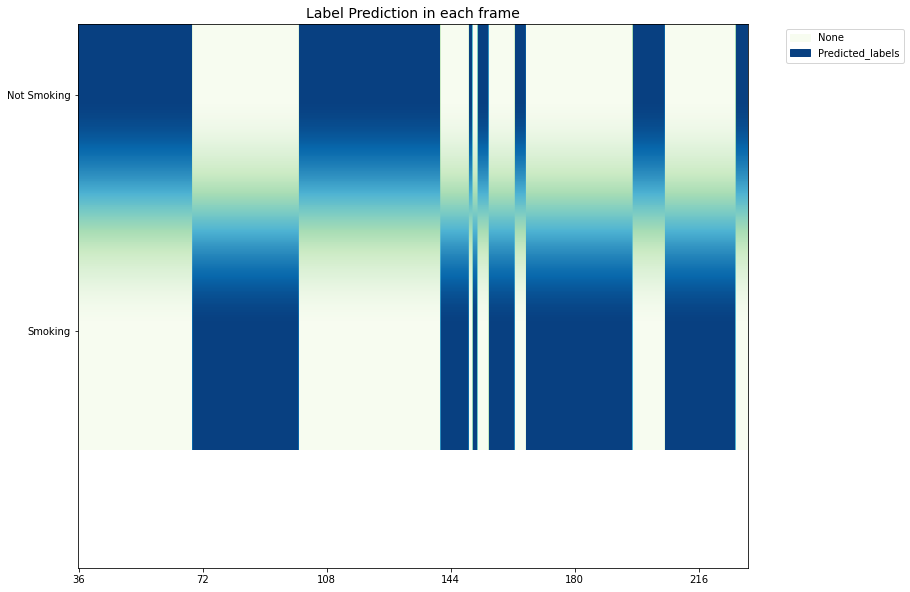

In [8]:
moments_in_seconds = main()
print(moments_in_seconds)

#Save the moments in a file
with open('/content/drive/My Drive/directed studies/testmoments.pkl', 'wb') as fp:
    pickle.dump(moments_in_seconds, fp)

In [21]:
#load the moments from the file
import pickle
with open ('/content/drive/My Drive/directed studies/testmoments.pkl', 'rb') as fp:
    itemlist = pickle.load(fp)

print(itemlist)
print(len(itemlist))

[[3.202964705882353, 6.038923039215686], [9.875807843137256, 10.609820588235294], [10.743277450980393, 10.843370098039216], [11.17701225490196, 11.84429656862745], [12.177938725490197, 15.01389705882353], [15.914730882352941, 17.783126960784315]]
6


In [ ]:
#merge the moments that are less than 1 second apart
result = []
result.append(itemlist[0])
for item in itemlist[1:]:
  if item[0] - result[-1][1] < 1:
    result[-1][1] = item[1]
  else:
    result.append(item)

print(result)
print(len(result))


[[1.2095416666666665, 1.4597916666666666], [2.6693333333333333, 3.294958333333333], [8.75875, 8.75875], [10.218541666666665, 14.347666666666665], [18.5185, 54.72133333333333], [59.184124999999995, 60.64391666666666], [62.52079166666666, 64.5645], [66.191125, 67.442375], [68.86045833333333, 71.61320833333333], [76.74333333333333, 82.54079166666666], [85.460375, 98.05629166666667], [99.64120833333332, 101.26783333333333], [102.477375, 102.477375], [108.39995833333333, 129.33754166666665], [141.266125, 141.30783333333332], [142.517375, 203.53666666666666], [208.208, 208.37483333333333], [210.54366666666664, 210.91904166666666], [216.841625, 217.71749999999997], [237.82091666666665, 238.90533333333332], [248.53995833333332, 248.53995833333332], [251.7515, 253.83691666666664]]
22


In [ ]:
#Remove the moments that are shorter than 1 second and create the json format that is needed for ilab website
#change the videoId accordingly


moments_json = {
    "videoId" : "1uNq_9wb_mo",
    "type" : "segment",
    "startTime" : 0,
    "endTime" : 0,
    "observer" : "LCRN model",
    "isHuman" : False,
    "confirmedBySomeone" : False,
    "rejectedBySomeone" : False,
    "observation" : {
        "label" : "Smoking",
        "labelConfidence" : 0.89
    }

}

moment_list = []
for moment in result:
  if moment[1] - moment[0] < 1:
    continue
  moments_json["startTime"] = round(moment[0], 3)
  moments_json["endTime" ] = round(moment[1], 3)
  print(moment)
  moment_list.append(moments_json.copy())

print(moment_list)
print(len(moment_list))

[10.218541666666665, 14.347666666666665]
[18.5185, 54.72133333333333]
[59.184124999999995, 60.64391666666666]
[62.52079166666666, 64.5645]
[66.191125, 67.442375]
[68.86045833333333, 71.61320833333333]
[76.74333333333333, 82.54079166666666]
[85.460375, 98.05629166666667]
[99.64120833333332, 101.26783333333333]
[108.39995833333333, 129.33754166666665]
[142.517375, 203.53666666666666]
[237.82091666666665, 238.90533333333332]
[251.7515, 253.83691666666664]
[{'videoId': '1uNq_9wb_mo', 'type': 'segment', 'startTime': 10.219, 'endTime': 14.348, 'observer': 'LCRN model', 'isHuman': False, 'confirmedBySomeone': False, 'rejectedBySomeone': False, 'observation': {'label': 'Smoking', 'labelConfidence': 0.89}}, {'videoId': '1uNq_9wb_mo', 'type': 'segment', 'startTime': 18.518, 'endTime': 54.721, 'observer': 'LCRN model', 'isHuman': False, 'confirmedBySomeone': False, 'rejectedBySomeone': False, 'observation': {'label': 'Smoking', 'labelConfidence': 0.89}}, {'videoId': '1uNq_9wb_mo', 'type': 'segmen

In [ ]:
import json
with open('/content/drive/My Drive/directed studies/testvideos/filename.json', 'w') as fout:
    json.dump(moment_list, fout)